In [1]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from random import seed
from sklearn import preprocessing
from torch.nn.init import kaiming_uniform_
seed(5)

In [2]:
import numpy as np
import gym
from tqdm import tqdm
import random as rand
from itertools import count

In [3]:
env = gym.make("CartPole-v0")

In [4]:
class ReplayMemory():
    def __init__(self,capacity):   
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count%self.capacity] = experience
        self.push_count+=1
    
    def sample(self, batch_size):
        return rand.sample(self.memory,batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory)>=batch_size

In [5]:
def extract_tensors(experiences):
    batch = Xp(*zip(*experiences))
    state = np.stack(batch.state) #stack
    action = np.stack(batch.action)
    next_state = np.stack(batch.next_state)
    reward = np.stack(batch.reward)
    done = np.stack(batch.done)
    return state,action,next_state,reward,done

In [6]:
from collections import namedtuple
Xp = namedtuple('Experience',
                        ('state', 'action', 'next_state', 'reward', 'done'))
Xp_points = Xp(5,6,7,8,9)
Xp_points

Experience(state=5, action=6, next_state=7, reward=8, done=9)

In [7]:
class linearApproximator(nn.Module):
    def __init__(self,state_shape,n_fc1,n_fc2, action_n):
        super(linearApproximator, self).__init__()
        self.input_size = state_shape
        self.n_fc1 = n_fc1
        self.n_fc2 = n_fc2
        self.out = action_n
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.fc1  = nn.Linear(self.input_size,self.n_fc1)
        self.fc2  = nn.Linear(self.n_fc1,self.n_fc2)
        
        self.state_value = nn.Linear(self.n_fc2, 1)
        self.advantage_actions  = nn.Linear(self.n_fc2,self.out)
        
        
        self.to(self.device)
        
    def forward(self, state_shape):
        x = self.fc1(state_shape)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        
        
        actions_ = self.advantage_actions(x)
        actions_ = F.relu(actions_)
        state_value_=self.state_value(x)
        state_value_=F.relu(state_value_)
        state_value_ = state_value_.expand_as(actions_)
        #adabantage function equation pg:311 - 316
        q = state_value_ + (actions_ - actions_.mean().expand_as(actions_))
        return q

In [8]:
def update_networks(online_network, target_network, tau):
    #polyak averaging: pg:319
    for target_weights, online_weights in zip(target_network.parameters(), online_network.parameters()):
        target_weight_update = (1.0 - tau)*target_weights.data
        online_weight_update = tau*online_weights.data
        sum_up = target_weight_update + online_weight_update
        target_weights.data.copy_(sum_up)
    return online_network, target_network

In [9]:
def update_online_model(experience_samples, online_network, target_network, gamma, optimizer):
    states, actions, next_states, rewards, done = extract_tensors(experience_samples)
    
    states = torch.tensor(states).float()
    actions = torch.tensor(actions)
    actions = actions.type(torch.LongTensor)
    actions = actions.unsqueeze(1)
    next_states=torch.tensor(next_states).float()
    rewards = torch.tensor(rewards).float()
    done = torch.tensor(done).float()
    
    
    q_online_next_states = online_network(next_states)#we now take next_states from online network 
    q_online_next_states = q_online_next_states.max(1)[1]#we now take the indices and not the values from online network
    q_online_next_states = q_online_next_states.unsqueeze(1)#iindices
     
    
    q_target_next_states_action = target_network(next_states)
    q_target_next_states_action = q_target_next_states_action.detach()#always make sure detach on target net
    q_target_next_states_action = q_target_next_states_action.gather(1, q_online_next_states)
    #print(q_target_next_states_action.shape)
    done = done.unsqueeze(1)
    
    #print(q_target_next_states_action.shape, done.shape)
    
    q_target_next_states_action *=(1 - done) 
    rewards = rewards.unsqueeze(1)
    q_target = rewards + (gamma*q_target_next_states_action)
    
    
    q_online_state = online_network(states)
    q_online_state = q_online_state.gather(1, actions)
    
    q_u_loss = torch.nn.SmoothL1Loss()
    q_u_loss = q_u_loss(q_online_state,q_target)
    
    optimizer.zero_grad()
    q_u_loss.backward()
    optimizer.step()
    return online_network, target_network

In [10]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

In [11]:
def select_action(state, model, epsilon):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state = torch.tensor(state).float()
    with torch.no_grad():
        q_values= model(state).cpu().detach()
        q_values = q_values.data.numpy().squeeze()
    if np.random.rand() > epsilon:
        action = np.argmax(q_values)
    else:
        action = np.random.randint(len(q_values))
    return action

In [12]:
def epsilon_decay_linear(init_eps, min_eps, decay_ratio, timestep, timestep_max):
    decay_t_step = timestep_max*decay_ratio
    epsilon = 1 - timestep/decay_t_step
    epsilon *= init_eps-min_eps
    epsilon+=min_eps
    epsilon = np.clip(epsilon, min_eps, init_eps)
    return epsilon

In [56]:
def Duelling_DDQN_(env,
         gamma=0.99,
         memory_size = 50000,
         init_epsilon=1.0,
         min_epsilon=0.3,
         epsilon_decay_ratio=0.001,
         tau = 0.005,
         target_update = 1000,
         min_sample_size=320,
         batch_size = 64,
         n_ep=20000,
         max_t_steps = 100000):
    
    action_space = env.action_space.n
    observation_space = len(env.reset())
    hidden_1 = 512
    hidden_2 = 128
    
    online_network = linearApproximator(observation_space, hidden_1, hidden_2, action_space)
    target_network = linearApproximator(observation_space, hidden_1, hidden_2, action_space)
    target_network.eval()
    target_network = freeze_model(target_network)
    
    optimizer = torch.optim.RMSprop(online_network.parameters(),lr=0.0007)
    memory = ReplayMemory(memory_size)
    
    t_step = 0 #important
    reward_per_ep = []
    
    for e in tqdm(range(n_ep)):
        state = env.reset()
        reward_accumulated = 0
        while True:
            epsilon = epsilon_decay_linear(init_epsilon, min_epsilon, epsilon_decay_ratio, t_step, max_t_steps)
            action = select_action(state, online_network, epsilon)
            next_state, reward, done, info = env.step(action)
            reward_accumulated+=reward
            is_truncated = 'TimeLimit.truncated' in info and\
                                info['TimeLimit.truncated']
            is_failure = done and not is_truncated
    
            memory.push(Xp(state, action, next_state, reward, is_failure))
            state = next_state
            t_step+=1
            if memory.can_provide_sample(min_sample_size):
                experience_samples = memory.sample(batch_size)
                online_network, target_network = update_online_model(experience_samples, online_network, target_network, gamma, optimizer)
            if t_step%target_update:
                online_network, target_network = update_networks(online_network, target_network, tau)
            if done == True:
                reward_per_ep.append(reward_accumulated)
                break
            if t_step > max_t_steps:
                return online_network, reward_per_ep
    online_network, reward_per_ep

In [57]:
seed(5)
model, rewards = Duelling_DDQN_(env)

  8%|██████▏                                                                    | 1638/20000 [07:43<1:26:31,  3.54it/s]


In [58]:
from scipy.ndimage.filters import uniform_filter1d
arr = uniform_filter1d(rewards, size=10)

In [59]:
from matplotlib import pyplot as plt
x = []
y = []
for i,e in enumerate(arr):
    y.append(i)
    x.append(e)

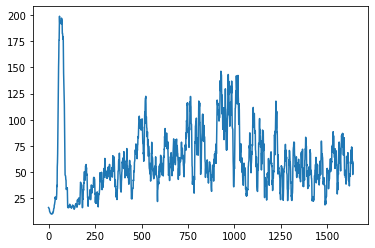

In [60]:
plt.plot(y, x)#tau 0.1, t = 10 0.01 decay, corrected, added min_sample sixe and batch_size

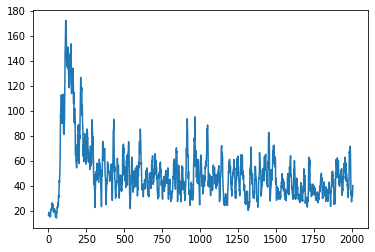

In [53]:
plt.plot(y, x)#tau 0.1, t = 10 0.01 decay, corrected, added min_sample sixe and batch_size

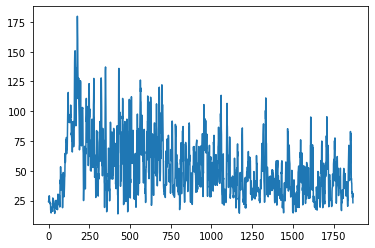

In [28]:
plt.plot(y, x)#tau 0.1, t = 10 0.01 decay, corrected, added min_sample sixe and batch_size

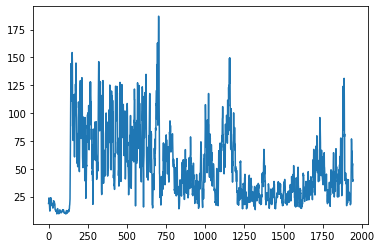

In [21]:
plt.plot(y, x)#tau 0.1, t = 10 0.01 decay, corrected, added min_sample sixe and batch_size

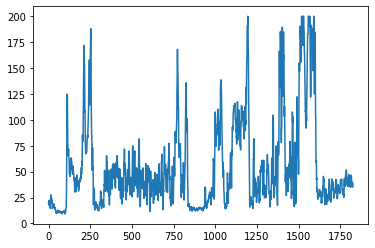

In [191]:
plt.plot(y, x)#tau 0.01, t = 100 0.01 decay, corrected, added min_sample sixe and batch_size